<a href="https://colab.research.google.com/github/TruongGiangVu/Face_Recognition_CNN_Model/blob/master/Face_CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount to drive for querying dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir("./drive/My Drive/")
print(os.getcwd())

/content/drive/My Drive


Import lib

In [3]:
#import lib
import datetime
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from keras.models import Model, load_model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers

from keras import regularizers
import cv2
import pandas as pd
import glob
from tqdm import tqdm

import time

Using TensorFlow backend.


In [4]:
def showImages(imgs):
    if(type(imgs) == list):
        for img in imgs:
            plt.figure()
            plt.imshow(img)
    else:
        plt.imshow(imgs)

    plt.show()

Clone from github to get AlignDlib

In [5]:
#align face, clone from github
!git clone https://github.com/TessFerrandez/research-papers.git
%cd research-papers/facenet
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    # return img
    return img[...,::-1]

# Initialize the OpenFace face alignment utility
# alignment = AlignDlib('models/landmarks.dat')
alignment = AlignDlib('/content/drive/My Drive/colab/shape_predictor_68_face_landmarks.dat') 
def align_image(img, size):
    return alignment.align(size, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

fatal: destination path 'research-papers' already exists and is not an empty directory.
/content/drive/My Drive/research-papers/facenet


Resize Image, if dsize = (None, None), keep old size of image 

In [6]:
# resize image by dsize =( 128, 128)
def resizeImage(img, dsize):
  sizeImg = (img.shape[0],img.shape[1])
  if sizeImg != dsize and dsize != (None, None):
    img = cv2.resize(img,dsize)
  return img

Class contains base, name, part, image 

In [7]:
#class contains base, name ,part, image  :path
import os.path
from pathlib import Path

class IdentityMetadata():
    def __init__(self, base, name, part, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.part = part
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.part, self.file) 
    
def load_metadata(path, part = ''):
    metadata = []
    count = 0
    for i in os.listdir(path):
        my_file = Path(os.path.join(path, i, part))
        if my_file.is_dir():
          len = countFile(my_file)
          if len >= 4:
            for f in os.listdir(my_file):
                # print(path, i, part, f)
                metadata.append(IdentityMetadata(path, i, part, f))
        print(count , end =" ")
        count =count +1
    return np.array(metadata)
def countFile(path):
  n = 0
  for i in os.listdir(path):
    n= n + 1
  return n


Load Images and label

In [8]:
def getXYMetadata(metadata,dsize, align = False):
  x_metadata = []
  y_metadata = []
  count = 0
  for m in metadata:
    img = load_image(m.image_path())
    img = resizeImage(img,dsize)
    if (align):
      img = align_image(img, dsize[0])
    if ( img is not None):
      y_metadata.append(m.name)
      x_metadata.append(img)
    print(count, end=" ")
    count = count + 1
  return x_metadata, y_metadata


Split x_train, x_test, y_train, y_test

In [9]:
# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(x_metadata, y_metadata, test_size=0.3, random_state=42)
# print(len(x_train), len(y_train), len(x_test), len(y_test))
def getDatabyIndex(list1, index):
  a = []
  n = len(list1)
  for i in range(n):
    if ( index[i] == True):
      a.append(list1[i])
  return a
def splitTrainTestByIndex(x_metadata, y_metadata, numSplit):
  amount = len(x_metadata)
  train_idx = np.arange(amount) % numSplit != 0
  test_idx = np.arange(amount) % numSplit == 0
  x_train = np.array(getDatabyIndex(x_metadata,train_idx))
  x_test = np.array(getDatabyIndex(x_metadata,test_idx))
  y_train = np.array(getDatabyIndex(y_metadata,train_idx))
  y_test = np.array(getDatabyIndex(y_metadata,test_idx))
  return x_train, x_test, y_train, y_test


Format x,y-Train,Test for fitting model

In [10]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

#reshape data to fit model
def reshapeData(x_train, x_test,dsize):
  num_train = x_train.shape[0]
  num_test = x_test.shape[0]
  x_train = x_train.reshape(num_train,dsize[0],dsize[1],3)
  x_test = x_test.reshape(num_test,dsize[0],dsize[1],3)
  return x_train, x_test

#encoder label to train in model
def encoderLabel(y_train, y_test):
  encoder = LabelEncoder()
  encoder.fit(y_train)
  y_train1 = encoder.fit_transform(y_train)
  y_test1 = encoder.fit_transform(y_test)

  num_classes=len(np.unique(y_train))
  y_train2 = np_utils.to_categorical(y_train1, num_classes=len(np.unique(y_train)))
  y_test2 = np_utils.to_categorical(y_test1, num_classes=len(np.unique(y_test)))
  return y_train2, y_test2, num_classes

M***ain program***

In [11]:
part = 'full_face'
a = load_metadata('/content/drive/My Drive/lfw-deepfunneled-parts', part)
print()
print(len(a))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [12]:
# select amount of data
metadata=a[:]

In [13]:
#size Image
heightDefault= 128
weightDefault= 128
dsize =(heightDefault, weightDefault)
# dsize =(None, None)

In [14]:
x_metadata, y_metadata = getXYMetadata(metadata, dsize)
print()
print(len(x_metadata))
print(len(y_metadata))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [15]:
#get dsize from original size of images (if dsize= (None ,None))
print(x_metadata[1].shape)
# if (dsize == (None, None)):
#   heightDefault= x_metadata[1].shape[0]
#   weightDefault= x_metadata[1].shape[1]
#   dsize =(heightDefault, weightDefault)
print("dsize",dsize)

(128, 128, 3)
dsize (128, 128)


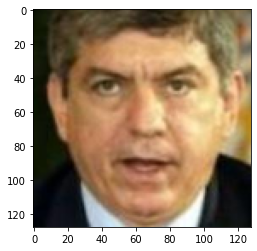

Cesar_Gaviria


In [16]:
showImages(x_metadata[8])
print(y_metadata[8])

In [17]:
x_train, x_test, y_train_original, y_test_original = splitTrainTestByIndex(x_metadata, y_metadata, 4)
print("Split train test")
print("x_train",x_train.shape)
print("x_test",x_test.shape)
print("y_train",y_train_original.shape)
print("y_test",y_test_original.shape)
print()

original_data = np.unique(y_train_original)
# print(original_data)

x_train, x_test = reshapeData(x_train, x_test, dsize)
y_train, y_test, num_classes = encoderLabel(y_train_original, y_test_original)
print("Format train test")
print("x_train",x_train.shape)
print("x_test",x_test.shape)
print("y_train",y_train.shape)
print("y_test",y_test.shape)
print(num_classes)
print()

Split train test
x_train (4754, 128, 128, 3)
x_test (1585, 128, 128, 3)
y_train (4754,)
y_test (1585,)

Format train test
x_train (4754, 128, 128, 3)
x_test (1585, 128, 128, 3)
y_train (4754, 574)
y_test (1585, 574)
574



CNN Model, using Sequential

In [18]:
#build Model
#old model
def defineModel(dsize, num_classes):
  inputs = Input(shape=(dsize[0], dsize[1], 3))

  net = Conv2D(32, kernel_size=1, strides=1, padding='same', activation='relu')(inputs)
  net = MaxPooling2D(pool_size=2)(net)

  net = Conv2D(64, kernel_size=1, strides=1, padding='same', activation='relu')(net)
  net = MaxPooling2D(pool_size=2)(net)

  net = Conv2D(128, kernel_size=1, strides=1, padding='same', activation='relu')(net)
  net = MaxPooling2D(pool_size=2)(net)

  net = Conv2D(256, kernel_size=1, strides=1, padding='same', activation='relu')(net)
  net = MaxPooling2D(pool_size=2)(net)

  net = Flatten()(net)

  net = Dense(512)(net)
  net = Activation('relu')(net)
  net = Dense(1)(net)

  net = Dense(num_classes, activation='softmax')(net)

  outputs = Activation('sigmoid')(net)

  model = Model(inputs=inputs, outputs=outputs)

  # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.compile(optimizer=optimizers.RMSprop(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

#current model
def defineModelSequential(dsize, num_classes):
  model = Sequential()
  model.add(Conv2D(32,(3,3), padding="same", activation='relu',input_shape=(dsize[0], dsize[1], 3)))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64,(3,3), padding="same", activation='relu' ))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128,(3,3), padding="same", activation='relu' ))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(256,(3,3), padding="same", activation='relu' ))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Dropout(0.2))
  model.add(Flatten())

  model.add(Dense(num_classes, activation='softmax'))
  model.compile(optimizer='Adam', 
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [19]:
def fitModel(model, x_train, x_test, y_train, y_test, pathWeightsBest):
  tic = time.time()

  model.summary()

  early_stoping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max')
  save_checkpoint = ModelCheckpoint(pathWeightsBest, monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = True, mode='max')
  reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2, patience = 1, min_lr = 1e-8, verbose=1)
  callbacks = [early_stoping, reduce_lr, save_checkpoint]

  history = model.fit(x_train, y_train, 
            epochs=20, 
            batch_size=64,
            shuffle=True,
            validation_data = (x_test, y_test),
            verbose=1,
            callbacks=callbacks)

  toc = time.time()
  print("TRAINING TIME: ", toc-tic)
  return model, history

Fit model and save best weights

In [20]:
model = defineModelSequential(dsize, num_classes)
pathWeightsBest = "/content/drive/My Drive/save_model/best_model_{}.hdf5".format(part)
print(pathWeightsBest)
model, history = fitModel(model, x_train, x_test, y_train, y_test, pathWeightsBest)

/content/drive/My Drive/save_model/best_model_full_face.hdf5
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 128)       0         
___________________________________________________________

In [21]:
#decode 
def decode_categorial(encoded_data, original_data):
    position = np.argmax(encoded_data)
    return original_data[position]

In [22]:
predict = model.predict(x_test[:])
count = 0 
for i in predict:
  name = decode_categorial(i, original_data)
  expected = y_test_original[count]
  print( "Index:{}, predict value = {}, expected value = {}".format(count,name, expected) )
  print()
  count = count + 1

Index:0, predict value = George_W_Bush, expected value = Celine_Dion

Index:1, predict value = Queen_Rania, expected value = Celine_Dion

Index:2, predict value = Jack_Straw, expected value = Cesar_Gaviria

Index:3, predict value = Amelie_Mauresmo, expected value = Cesar_Gaviria

Index:4, predict value = Donald_Rumsfeld, expected value = Chanda_Rubin

Index:5, predict value = Colin_Powell, expected value = Charles_Moose

Index:6, predict value = Angelina_Jolie, expected value = Charles_Moose

Index:7, predict value = Kofi_Annan, expected value = Charles_Moose

Index:8, predict value = Mahmoud_Abbas, expected value = Charles_Taylor

Index:9, predict value = Alejandro_Toledo, expected value = Charles_Taylor

Index:10, predict value = Charles_Taylor, expected value = Charles_Taylor

Index:11, predict value = Edmund_Stoiber, expected value = Charlton_Heston

Index:12, predict value = Hugo_Chavez, expected value = Chen_Shui-bian

Index:13, predict value = Pedro_Almodovar, expected value = C

In [23]:
loss, accuracy  = model.evaluate(x_test, y_test, verbose=0)
print("loss: ", loss)
print("accuracy:",accuracy)

loss:  7.892088254693931
accuracy: 0.39810726046562195


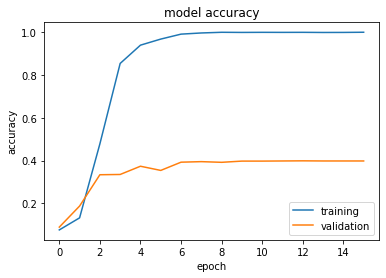

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [25]:
#load weights from file hdf5
model = defineModelSequential(dsize, num_classes)
model.load_weights(pathWeightsBest)

loss, accuracy  = model.evaluate(x_test, y_test, verbose=0)
print("loss: ", loss)
print("accuracy:",accuracy)

loss:  7.852910802793051
accuracy: 0.39873817563056946
